In [1]:
import torch
import torch.nn as nn
import cv2
import numpy as np

import os
import matplotlib.pyplot as plt
import time

from collections.abc import Iterable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

In [2]:
HEIGHT = 400
WIDTH = 320

In [3]:
class ImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2RGB, transform=transforms.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(os.path.join(path, file)) for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]

        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
            return imgs
        else:
            return self.transform(self.imgs[subscript])

    def l_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[:1, :, :])
        return imgs

    def ab_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[1:, :, :])
        return imgs

#### Custom transformation class to resize images with ```OpenCV``` and later this class instance use with other transformation classes with ```transforms.Compose```.

In [4]:
class OpenCVResize(object):

    def __init__(self, size):
        assert isinstance(size, int) or isinstance(size, Iterable) and len(size) == 2
        self.size = size

    def __call__(self, pic):
        return cv2.resize(np.array(pic), dsize=self.size, interpolation=cv2.INTER_NEAREST)


In [5]:
tf = transforms.Compose({
    OpenCVResize(size=(WIDTH, HEIGHT)),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
})

gray_dataset = ImageDataset(path='../dataset/faces/color', transform=tf, code=cv2.COLOR_BGR2GRAY)
lab_dataset = ImageDataset(path='../dataset/faces/color', transform=tf, code=cv2.COLOR_BGR2LAB)

In [6]:
torch.manual_seed(72)

# GRAYSCALE IMAGES USE TO TRAIN NEURAL NETWORKS.
gray_data_loader = DataLoader(dataset=gray_dataset, batch_size=10, shuffle=False)
# LAB IMAGES FOR VISUALIZATION AND TRAINING PURPOSE.
lab_data_loader = DataLoader(dataset=lab_dataset, batch_size=10, shuffle=False)
l_data_loader = DataLoader(dataset=lab_dataset.l_images(), batch_size=10, shuffle=False)
ab_data_loader = DataLoader(dataset=lab_dataset.ab_images(), batch_size=10, shuffle=False)

#### View a single batch grayscale and colored image sample.

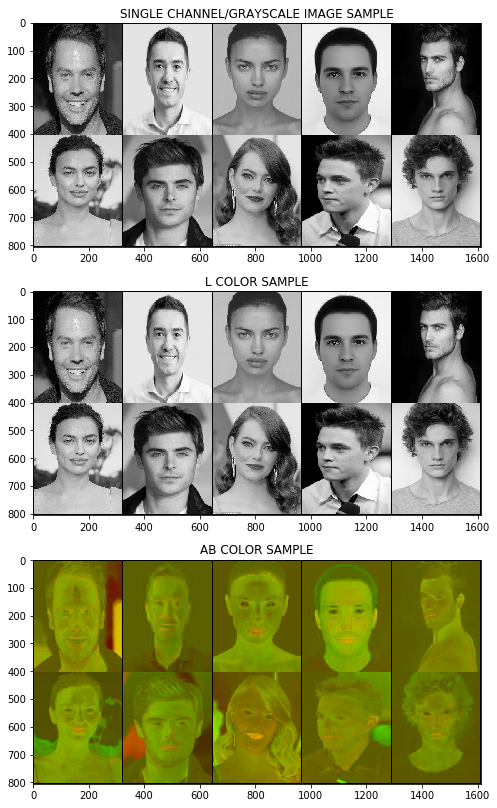

In [7]:
g_ims, l_ims, ab_ims, lab_ims = (None, None, None, None)
for g_ims in gray_data_loader:
    break

for l_ims in l_data_loader:
    break

for ab_ims in ab_data_loader:
    break

for lab_ims in lab_data_loader:
    break

plt.figure(figsize=(13, 14))

im = make_grid(g_ims, nrow=5, normalize=True)

plt.subplot(311)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("SINGLE CHANNEL/GRAYSCALE IMAGE SAMPLE")

im = make_grid(l_ims, nrow=5, normalize=True)

plt.subplot(312)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title("L COLOR SAMPLE")

im = make_grid(ab_ims, nrow=5, normalize=True)
im = np.stack([im[0], im[1], np.zeros((im.shape[1], im.shape[2]))])

plt.subplot(313)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title('AB COLOR SAMPLE')

plt.show()

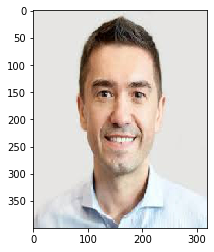

In [8]:
stack = np.stack([l_ims[1][0], ab_ims[1, 0], ab_ims[1, 1]], axis=0)
stack *= 255

stack = np.transpose(stack, (1, 2, 0)).astype(np.uint8)
stack = cv2.cvtColor(stack, code=cv2.COLOR_LAB2RGB)
plt.imshow(stack)

####  Convolutional Neural Network Model

In [9]:
class RGBNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=2, n_layers=(128, 64, 64, 32)):
        super().__init__()

        layers = []

        for nl in n_layers:
            layers.append(nn.Conv2d(in_channels=in_channels,
                                    out_channels=nl,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1))
            layers.append(nn.BatchNorm2d(nl))
            layers.append(nn.ReLU())
            in_channels = nl

        layers.append(nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=3,
                                stride=1,
                                padding=1))

        self.sequence = nn.Sequential(*layers)

    def forward(self, X):
        return self.sequence(X)


model = RGBNet()
model

RGBNet(
  (sequence): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

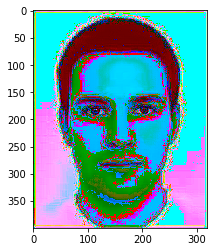

In [10]:
s = model(l_ims[3].view(-1, 1, HEIGHT, WIDTH))
s = torch.stack([l_ims[3][0], s[0, 0], s[0, 1]]) * 255
s = np.transpose(s.detach().view(-1, HEIGHT, WIDTH).numpy(), axes=(1, 2, 0)).astype(np.uint8)
s = cv2.cvtColor(s, code=cv2.COLOR_LAB2RGB)

plt.imshow(s)

#### Training Neural Network Models


In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
epoch = 5
losses = []

start = time.time()

for i in range(epoch):
    i += 1

    # TRAIN RED MODEL.
    for batch, (X, y) in enumerate(zip(l_data_loader, ab_data_loader)):
        batch += 1

        y_pred = model(X)
        loss = criterion(y_pred, y)

        losses.append(loss)

        if batch % 2 == 0 or (batch == 1 or batch == 7):
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

duration = time.time() - start
print(f'Duration to total execution: {duration / 60:.2f} minutes')

Epoch: 1, Batch: 1 -> Loss: 0.8390415906906128
Epoch: 1, Batch: 2 -> Loss: 0.6158283948898315
Epoch: 1, Batch: 4 -> Loss: 0.24721498787403107
Epoch: 1, Batch: 6 -> Loss: 0.31422850489616394
Epoch: 1, Batch: 7 -> Loss: 0.1199093759059906
Epoch: 2, Batch: 1 -> Loss: 0.04600687697529793
Epoch: 2, Batch: 2 -> Loss: 0.08181122690439224
Epoch: 2, Batch: 4 -> Loss: 0.11794152855873108
Epoch: 2, Batch: 6 -> Loss: 0.04539676383137703
Epoch: 2, Batch: 7 -> Loss: 0.032969001680612564
Epoch: 3, Batch: 1 -> Loss: 0.03576274961233139
Epoch: 3, Batch: 2 -> Loss: 0.0374235138297081
Epoch: 3, Batch: 4 -> Loss: 0.05458850786089897
Epoch: 3, Batch: 6 -> Loss: 0.03933876007795334
Epoch: 3, Batch: 7 -> Loss: 0.017389193177223206
Epoch: 4, Batch: 1 -> Loss: 0.010297012515366077
Epoch: 4, Batch: 2 -> Loss: 0.016472794115543365
Epoch: 4, Batch: 4 -> Loss: 0.017321661114692688
Epoch: 4, Batch: 6 -> Loss: 0.01839216984808445
Epoch: 4, Batch: 7 -> Loss: 0.01231080386787653
Epoch: 5, Batch: 1 -> Loss: 0.005530685

Text(0, 0.5, 'Loss')

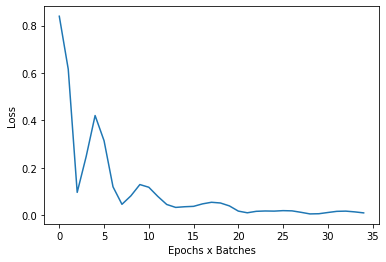

In [15]:
plt.plot(losses)
plt.xlabel('Epochs x Batches')
plt.ylabel('Loss')

#### Validate images with same dataset used to train.

In [16]:
@torch.no_grad()
def validate(img):

    model.eval()

    ab = model(img)
    lab = np.stack([img[0, 0], ab[0, 0], ab[0, 1]]) * 255

    lab = np.transpose(lab, axes=(1, 2, 0)).astype(np.uint8)
    lab = cv2.cvtColor(lab, code=cv2.COLOR_LAB2RGB)

    plt.imshow(lab)

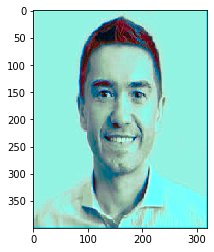

In [17]:
validate(g_ims[1].view(-1, 1, HEIGHT, WIDTH))

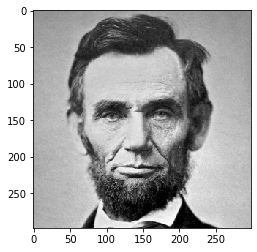

In [19]:
img = cv2.imread('../dataset/faces/grayscale/gray_face (1).png', flags=cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

img = torch.FloatTensor(img).view(-1, 1, 298, 298) / 255

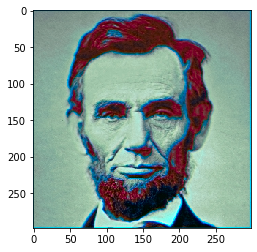

In [20]:
validate(img)